In [ ]:
#uplist[uplist['shcode']=='000080']
#uplist[uplist['shcode']=='000080'].groupby(['shcode']).count()
#tmlist[tmlist['shcode']=='000080']
#tmlist[tmlist['shcode']=='000080'].groupby(['shcode']).count()
#df_bfaf2 = df_bfaf[['index','shcode']].drop_duplicates()

'''
#4-1 분리
s = df['index'].str.split(' ').apply(Series,1)#.fillna(0)
df = pd.merge(df, s,left_index =True, right_index =True ,how = 'left')
df['total_n'] = s.groupby(s.index).count().sum(axis=1)
del df['index']
df = df.fillna(0)
df = pd.merge(df, uplist[['shcode','upcode', 'upname']], how = 'left', on = ['shcode'])
df = pd.merge(df, tmlist[['shcode','tmcode', 'tmname']], how = 'left', on = ['shcode'])
df = pd.merge(df, shcode_list, how = 'left', on = ['shcode'])

df.groupby(['upcode','upname'])['total_n'].count().sort_values(ascending= False)
df.groupby(['tmcode','tmname'])['total_n'].count().sort_values(ascending= False)

li = [x for x in range(0,12)]
df.columns.isin(li)
df2 = df.copy()
for i in df.columns[df.columns.isin(li)]:
    df2[i] = df2[i].str.slice(stop = 6) 
'''

In [1]:
import sqlite3
import time
import pandas as pd
import numpy as np
import query
import preprocesser
import datetime
import pandas.tseries.offsets as of  # for timeoffset
from pandas import Series

def non_decreasing(L):
    data = [x<=y for x, y in zip(L, L[1:])]
    return data

In [2]:
#1.종목명
shcode_list = query.query_shcode_list_today()

#2.target from csvs
df = pd.read_csv("high_ratio_0.05_volume_money_20000000000_v4.csv", 
                 dtype ={'shcode':str})
del df['Unnamed: 0']

#3.관련 업종 테마추출
uplist = query.query_up_distinct()
tmlist = query.query_tm_distinct()

#4- 2 분리
t = df['index'].str.split(' ').apply(Series,1).stack()
t.index = t.index.droplevel(-1)
t.name = 'target_day'
del df['index']
df = df.join(t)
df = pd.merge(df, uplist[['shcode','upcode', 'upname']], how = 'left', on = ['shcode'])
df = pd.merge(df, tmlist[['shcode','tmcode', 'tmname']], how = 'left', on = ['shcode'])
df = pd.merge(df, shcode_list, how = 'left', on = ['shcode'])
df['target_m'] = df['target_day'].str.slice(stop = 6)

#target_day_list
target_day_list = pd.to_datetime(df['target_day'], format = "%Y-%m-%d")

In [3]:
#y label 만들기
#다음 target_day와의 차이 계산

df['next_target_day'] = df['target_day'].shift(-1)

next_target_day_list = pd.to_datetime(df['next_target_day'], format = "%Y-%m-%d")
target_day_diff = next_target_day_list - target_day_list

# 다음 target_day shcode2
df['shcode2'] = df['shcode'].shift(-1)


# 0  : 1 : 한번이상
df['y'] = np.where((df['shcode'] == df['shcode2']) & (target_day_diff <= datetime.timedelta(days = 30)), 1, 0)

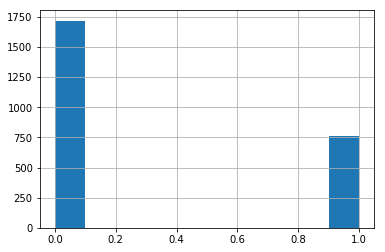

In [4]:
%matplotlib inline
df['y'].hist()

data_preprocessing 확인

In [5]:
#(1) for jupo
#interval calculate before 12 month 
init_jupo_timestamp = target_day_list + of.MonthBegin(n= -12)
end_jupo_timestamp = target_day_list
df['init_jupo'] = init_jupo_timestamp.apply(lambda x: x.strftime("%Y%m%d"))
df['end_jupo'] = end_jupo_timestamp.apply(lambda x: x.strftime("%Y%m%d"))
df = df.reset_index(drop = True)

#(2) 월
#interval calculate before 12 month , before 1 month
init_month_timestamp = target_day_list + of.MonthEnd(n= -12)
end_month_timestamp = target_day_list + of.MonthEnd(n= -1)
df['init_month'] = init_month_timestamp.apply(lambda x: x.strftime("%Y%m%d"))
df['end_month'] = end_month_timestamp.apply(lambda x: x.strftime("%Y%m%d"))

#(3) 주
#interval calculate before 30 weeks , before 1 weeks
init_week_timestamp = target_day_list + of.Week(n= -30, weekday = 4)
end_week_timestamp = target_day_list + of.Week(n= -1, weekday = 4)
df['init_week'] = init_week_timestamp.apply(lambda x: x.strftime("%Y%m%d"))
df['end_week'] = end_week_timestamp.apply(lambda x: x.strftime("%Y%m%d"))

#(4) 일
check_init_timestamp2 = target_day_list - datetime.timedelta(days=10)
df['check_init_day2'] = check_init_timestamp2.apply(lambda x: x.strftime("%Y%m%d"))

In [6]:
#(1)-1. 주포관련데이터 구하기

jupo = pd.DataFrame([], columns = ['shcode', 'date', 'max_vol', 'max_jupo','contin_jupo',
                                   'samo_vol_ratio', 'sec_vol_ratio', 'ins_vol_ratio',
                                   'tusin_vol_ratio', 'bank_vol_ratio','jong_vol_ratio', 
                                   'fund_vol_ratio', 'etcom_vol_ratio', 
                                   'for_reg_vol_ratio', 'for_noreg_vol_ratio', 'nat_no_vol_ratio', 
                                   'per_vol_ratio', 'com_vol_ratio', 'for_vol_ratio', 'etc_vol_ratio'])


#(1)-2. 주포관련obv 구하기

per_df = pd.DataFrame([],columns = ['date','shcode', 'obv'])

#(2) 월, (3) 주, (4) 일

rrr = pd.DataFrame([],columns = ['date','open_', 'low', 'high','close','volume', 'range_position', 'shcode', 'month_ma5_score',
                                 'week_ma5_score','week_ma20_score', 'week_golden_cross', 'week_dead_cross', 'week_up', 'week_down'])

In [7]:
for i,v in df['shcode'].items():
    print('===========',i, v, "시작",'===========')
    #(1)-1. 주포관련데이터 구하기
    # 총괄주식수 구하기
    a = query.query_finance(v)
    a['num_total'] = a['total_vol'].astype(int) * 1000

    # 투자자별 매매동향
    b = query.query_jupo_vol(v, fr=df['init_jupo'].iloc[i], to=df['end_jupo'].iloc[i])

    # cumsum index
    c = b.groupby(['shcode','date']).sum().cumsum()
    # multi index to single index
    c = c.reset_index(level=['shcode','date'])

    # calculate max volume
    c_for_value_ratio = c[['samo_vol', 'sec_vol', 'ins_vol', 'tusin_vol', 'bank_vol',
                           'jong_vol', 'fund_vol', 'etcom_vol', 'for_reg_vol', 'for_noreg_vol',
                           'nat_no_vol', 'per_vol', 'com_vol', 'for_vol', 'etc_vol']] / a['num_total'].iloc[0]

    c['max_vol'] = c_for_value_ratio.max(axis=1)
    c['max_jupo'] = c_for_value_ratio.idxmax(axis=1)

    c_for_value_ratio = c_for_value_ratio.rename(columns={'samo_vol' : 'samo_vol_ratio', 'sec_vol' : 'sec_vol_ratio', 
                                      'ins_vol' : 'ins_vol_ratio', 'tusin_vol' : 'tusin_vol_ratio', 'bank_vol' : 'bank_vol_ratio',
                                      'jong_vol' : 'jong_vol_ratio', 'fund_vol' : 'fund_vol_ratio', 'etcom_vol' : 'etcom_vol_ratio',
                                      'for_reg_vol' : 'for_reg_vol_ratio', 'for_noreg_vol' : 'for_noreg_vol_ratio',
                                      'nat_no_vol' : 'nat_no_vol_ratio', 'per_vol' : 'per_vol_ratio', 'com_vol' : 'com_vol_ratio',
                                      'for_vol' : 'for_vol_ratio', 'etc_vol' : 'etc_vol_ratio'})

    c_final = pd.concat([c, c_for_value_ratio], axis=1) # column bind

    jupo_result = c_final.tail(2)
    if jupo_result['max_jupo'].iloc[0] == jupo_result['max_jupo'].iloc[-1]:
        jupo_result['contin_jupo'] = 1
    else: 
        jupo_result['contin_jupo'] = 0

    jupo = jupo.append(jupo_result[['shcode', 'date', 'max_vol', 'max_jupo','contin_jupo','samo_vol_ratio', 'sec_vol_ratio', 'ins_vol_ratio',
                 'tusin_vol_ratio', 'bank_vol_ratio','jong_vol_ratio', 'fund_vol_ratio', 'etcom_vol_ratio', 
                 'for_reg_vol_ratio', 'for_noreg_vol_ratio', 'nat_no_vol_ratio', 
                 'per_vol_ratio', 'com_vol_ratio', 'for_vol_ratio', 'etc_vol_ratio']].iloc[-1])

    print(i , v , '1-1_끝')

    #(1)-2. 주포관련obv 구하기
    df_obv = query.query_ohlcv(shcode = df['shcode'].iloc[i],
                               fr=df['init_jupo'].iloc[i],
                               to=df['end_jupo'].iloc[i])
    #데이터전처리
    df_obv = preprocesser.obv(df_obv)
    df_obv['shcode'] = df['shcode'].iloc[i]

    per_df = per_df.append(df_obv[['date','shcode', 'obv']].tail(1))

    print(i , v , '1-2_끝')
    
    
    #(2) 월봉대세판단
    df_monthly = query.query_t1305_month(shcode = v, fr = df['init_month'].iloc[i], to = df['end_month'].iloc[i])

    #except1: data없는경우
    if df_monthly.shape[0] == 0:
        ma5 = None
        month_ma5_score = None
        pass
    else:
        # ma preprocesser
        df_monthly = preprocesser.sma_monthly(df_monthly)
        amount = [0.15, 0.15, 0.2, 0.2, 0.3]
        # 대세 판단1 : 월봉 5이평이 감소하지않음
        ma5 = non_decreasing(df_monthly['close_ma5'])[-5:]
        month_ma5_score = sum(x * y for x, y in zip(ma5, amount)) / sum(amount)
        
    #(3) 주봉대세판단
    df_weekly = query.query_t1305_week(shcode = v, fr = df['init_week'].iloc[i], to = df['end_week'].iloc[i])
    #except1: data없는경우
    if df_weekly.shape[0] ==0:
        continue
    # ma preprocesser
    df_weekly = preprocesser.sma_weekly(df_weekly)
    amount = [0.15, 0.15, 0.2, 0.2, 0.3]

    # 대세 판단1 : 주봉 5이평이 감소하지않음
    ma5 = non_decreasing(df_weekly['close_ma5'])[-5:]
    week_ma5_score = sum(x * y for x, y in zip(ma5, amount)) / sum(amount)

    # 대세 판단2 : 주봉 20이평이 감소하지않음
    ma20 = non_decreasing(df_weekly['close_ma20'])[-5:]
    week_ma20_score = sum(x * y for x, y in zip(ma20, amount)) / sum(amount)

    # 대세 판단3 : 주별확인
    # 1. 위에 1-1 위에stay, 1-2 데크, 2,아래  2-1 아래스테이 2-2. 골크
    close_ma5 = df_weekly['close_ma5'].iloc[-5:]
    close_ma20 = df_weekly['close_ma20'].iloc[-5:]

    prev_close_ma5 = df_weekly['close_ma5'].shift(1).iloc[-5:]
    prev_close_ma20 = df_weekly['close_ma20'].shift(1).iloc[-5:]

    week_golden_cross = np.where(((close_ma5 >= close_ma20) & (prev_close_ma5 <= prev_close_ma20)),1,0).sum() # gc
    week_dead_cross = np.where(((close_ma5 <= close_ma20) & (prev_close_ma5 >= prev_close_ma20)),1,0).sum() # dc
    week_up = np.where((close_ma5 >= close_ma20), 1, 0).sum() # 정배열
    week_down = np.where((close_ma5 < close_ma20), 1, 0).sum() # 역배열

    #(4) 일별확인
    df_daily = query.query_t1305(shcode = v, fr = df['check_init_day2'].iloc[i], to = df['target_day'].iloc[i])

    #종가상승률

    test_list = pd.DataFrame(dict(date = np.array(df_daily)[:,0],
                                  open_ = df_daily['open'],
                                  low = df_daily['low'],
                                  high = df_daily['high'],
                                  close = df_daily['close'],
                                  volume = df_daily['volume'],
                                  range_position = (df_daily['close']-df_daily['low'])/(df_daily['high']-df_daily['low']),
                                 ))

    test_list['shcode'] = v

    test_list['month_ma5_score'] = month_ma5_score

    test_list['week_ma5_score'] = week_ma5_score
    test_list['week_ma20_score'] = week_ma20_score
    
    test_list['week_golden_cross'] = week_golden_cross
    test_list['week_dead_cross'] =  week_dead_cross
    test_list['week_up'] = week_up
    test_list['week_down'] = week_down

    #if any(test_list['check']) == 1:
    rrr = rrr.append(test_list.tail(1))
    print(i, v, '2,3,4_완료')
    print('===========',i, v, "끝",'===========')

=========== 0 000080 시작 ===========


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0 000080 1-1_끝
0 000080 1-2_끝
0 000080 2,3,4_완료
=========== 0 000080 끝 ===========
=========== 1 000140 시작 ===========
1 000140 1-1_끝
1 000140 1-2_끝
1 000140 2,3,4_완료
=========== 1 000140 끝 ===========
=========== 2 000140 시작 ===========
2 000140 1-1_끝
2 000140 1-2_끝
2 000140 2,3,4_완료
=========== 2 000140 끝 ===========
=========== 3 000150 시작 ===========
3 000150 1-1_끝
3 000150 1-2_끝
3 000150 2,3,4_완료
=========== 3 000150 끝 ===========
=========== 4 000150 시작 ===========
4 000150 1-1_끝
4 000150 1-2_끝
4 000150 2,3,4_완료
=========== 4 000150 끝 ===========
=========== 5 000230 시작 ===========
5 000230 1-1_끝
5 000230 1-2_끝
5 000230 2,3,4_완료
=========== 5 000230 끝 ===========
=========== 6 000300 시작 ===========
6 000300 1-1_끝
6 000300 1-2_끝
6 000300 2,3,4_완료
=========== 6 000300 끝 ===========
=========== 7 000390 시작 ===========
7 000390 1-1_끝
7 000390 1-2_끝
7 000390 2,3,4_완료
=========== 7 000390 끝 ===========
=========== 8 000400 시작 ===========
8 000400 1-1_끝
8 000400 1-2_끝
8 000400 2,3,4_완료


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


9 000430 1-1_끝
9 000430 1-2_끝
9 000430 2,3,4_완료
=========== 9 000430 끝 ===========
=========== 10 000430 시작 ===========
10 000430 1-1_끝
10 000430 1-2_끝
10 000430 2,3,4_완료
=========== 10 000430 끝 ===========
=========== 11 000885 시작 ===========
11 000885 1-1_끝
11 000885 1-2_끝
11 000885 2,3,4_완료
=========== 11 000885 끝 ===========
=========== 12 000885 시작 ===========
12 000885 1-1_끝
12 000885 1-2_끝
12 000885 2,3,4_완료
=========== 12 000885 끝 ===========
=========== 13 000885 시작 ===========
13 000885 1-1_끝
13 000885 1-2_끝
13 000885 2,3,4_완료
=========== 13 000885 끝 ===========
=========== 14 000890 시작 ===========
14 000890 1-1_끝
14 000890 1-2_끝
14 000890 2,3,4_완료
=========== 14 000890 끝 ===========
=========== 15 000890 시작 ===========
15 000890 1-1_끝
15 000890 1-2_끝
15 000890 2,3,4_완료
=========== 15 000890 끝 ===========
=========== 16 000890 시작 ===========
16 000890 1-1_끝
16 000890 1-2_끝
16 000890 2,3,4_완료
=========== 16 000890 끝 ===========
=========== 17 000890 시작 ===========
17 000890 1-

75 002100 1-2_끝
75 002100 2,3,4_완료
=========== 75 002100 끝 ===========
=========== 76 002100 시작 ===========
76 002100 1-1_끝
76 002100 1-2_끝
76 002100 2,3,4_완료
=========== 76 002100 끝 ===========
=========== 77 002100 시작 ===========
77 002100 1-1_끝
77 002100 1-2_끝
77 002100 2,3,4_완료
=========== 77 002100 끝 ===========
=========== 78 002140 시작 ===========
78 002140 1-1_끝
78 002140 1-2_끝
78 002140 2,3,4_완료
=========== 78 002140 끝 ===========
=========== 79 002140 시작 ===========
79 002140 1-1_끝
79 002140 1-2_끝
79 002140 2,3,4_완료
=========== 79 002140 끝 ===========
=========== 80 002140 시작 ===========
80 002140 1-1_끝
80 002140 1-2_끝
80 002140 2,3,4_완료
=========== 80 002140 끝 ===========
=========== 81 002140 시작 ===========
81 002140 1-1_끝
81 002140 1-2_끝
81 002140 2,3,4_완료
=========== 81 002140 끝 ===========
=========== 82 002140 시작 ===========
82 002140 1-1_끝
82 002140 1-2_끝
82 002140 2,3,4_완료
=========== 82 002140 끝 ===========
=========== 83 002140 시작 ===========
83 002140 1-1_끝
83 00214

140 003535 1-1_끝
140 003535 1-2_끝
140 003535 2,3,4_완료
=========== 140 003535 끝 ===========
=========== 141 003560 시작 ===========
141 003560 1-1_끝
141 003560 1-2_끝
141 003560 2,3,4_완료
=========== 141 003560 끝 ===========
=========== 142 003560 시작 ===========
142 003560 1-1_끝
142 003560 1-2_끝
142 003560 2,3,4_완료
=========== 142 003560 끝 ===========
=========== 143 003580 시작 ===========
143 003580 1-1_끝
143 003580 1-2_끝
143 003580 2,3,4_완료
=========== 143 003580 끝 ===========
=========== 144 003580 시작 ===========
144 003580 1-1_끝
144 003580 1-2_끝
144 003580 2,3,4_완료
=========== 144 003580 끝 ===========
=========== 145 003580 시작 ===========
145 003580 1-1_끝
145 003580 1-2_끝
145 003580 2,3,4_완료
=========== 145 003580 끝 ===========
=========== 146 003850 시작 ===========
146 003850 1-1_끝
146 003850 1-2_끝
146 003850 2,3,4_완료
=========== 146 003850 끝 ===========
=========== 147 004060 시작 ===========
147 004060 1-1_끝
147 004060 1-2_끝
147 004060 2,3,4_완료
=========== 147 004060 끝 ===========
======

204 005390 1-1_끝
204 005390 1-2_끝
204 005390 2,3,4_완료
=========== 204 005390 끝 ===========
=========== 205 005390 시작 ===========
205 005390 1-1_끝
205 005390 1-2_끝
205 005390 2,3,4_완료
=========== 205 005390 끝 ===========
=========== 206 005420 시작 ===========
206 005420 1-1_끝
206 005420 1-2_끝
206 005420 2,3,4_완료
=========== 206 005420 끝 ===========
=========== 207 005690 시작 ===========
207 005690 1-1_끝
207 005690 1-2_끝
207 005690 2,3,4_완료
=========== 207 005690 끝 ===========
=========== 208 005690 시작 ===========
208 005690 1-1_끝
208 005690 1-2_끝
208 005690 2,3,4_완료
=========== 208 005690 끝 ===========
=========== 209 005690 시작 ===========
209 005690 1-1_끝
209 005690 1-2_끝
209 005690 2,3,4_완료
=========== 209 005690 끝 ===========
=========== 210 005690 시작 ===========
210 005690 1-1_끝
210 005690 1-2_끝
210 005690 2,3,4_완료
=========== 210 005690 끝 ===========
=========== 211 005690 시작 ===========
211 005690 1-1_끝
211 005690 1-2_끝
211 005690 2,3,4_완료
=========== 211 005690 끝 ===========
======

268 008060 1-1_끝
268 008060 1-2_끝
268 008060 2,3,4_완료
=========== 268 008060 끝 ===========
=========== 269 008060 시작 ===========
269 008060 1-1_끝
269 008060 1-2_끝
269 008060 2,3,4_완료
=========== 269 008060 끝 ===========
=========== 270 008350 시작 ===========
270 008350 1-1_끝
270 008350 1-2_끝
270 008350 2,3,4_완료
=========== 270 008350 끝 ===========
=========== 271 008350 시작 ===========
271 008350 1-1_끝
271 008350 1-2_끝
271 008350 2,3,4_완료
=========== 271 008350 끝 ===========
=========== 272 008350 시작 ===========
272 008350 1-1_끝
272 008350 1-2_끝
272 008350 2,3,4_완료
=========== 272 008350 끝 ===========
=========== 273 008350 시작 ===========
273 008350 1-1_끝
273 008350 1-2_끝
273 008350 2,3,4_완료
=========== 273 008350 끝 ===========
=========== 274 008350 시작 ===========
274 008350 1-1_끝
274 008350 1-2_끝
274 008350 2,3,4_완료
=========== 274 008350 끝 ===========
=========== 275 008355 시작 ===========
275 008355 1-1_끝
275 008355 1-2_끝
275 008355 2,3,4_완료
=========== 275 008355 끝 ===========
======

332 010100 1-1_끝
332 010100 1-2_끝
332 010100 2,3,4_완료
=========== 332 010100 끝 ===========
=========== 333 010140 시작 ===========
333 010140 1-1_끝
333 010140 1-2_끝
333 010140 2,3,4_완료
=========== 333 010140 끝 ===========
=========== 334 010400 시작 ===========
334 010400 1-1_끝
334 010400 1-2_끝
334 010400 2,3,4_완료
=========== 334 010400 끝 ===========
=========== 335 010420 시작 ===========
335 010420 1-1_끝
335 010420 1-2_끝
335 010420 2,3,4_완료
=========== 335 010420 끝 ===========
=========== 336 010420 시작 ===========
336 010420 1-1_끝
336 010420 1-2_끝
336 010420 2,3,4_완료
=========== 336 010420 끝 ===========
=========== 337 010600 시작 ===========
337 010600 1-1_끝
337 010600 1-2_끝
337 010600 2,3,4_완료
=========== 337 010600 끝 ===========
=========== 338 010600 시작 ===========
338 010600 1-1_끝
338 010600 1-2_끝
338 010600 2,3,4_완료
=========== 338 010600 끝 ===========
=========== 339 010600 시작 ===========
339 010600 1-1_끝
339 010600 1-2_끝
339 010600 2,3,4_완료
=========== 339 010600 끝 ===========
======

396 013000 1-1_끝
396 013000 1-2_끝
396 013000 2,3,4_완료
=========== 396 013000 끝 ===========
=========== 397 013360 시작 ===========
397 013360 1-1_끝
397 013360 1-2_끝
397 013360 2,3,4_완료
=========== 397 013360 끝 ===========
=========== 398 013700 시작 ===========
398 013700 1-1_끝
398 013700 1-2_끝
398 013700 2,3,4_완료
=========== 398 013700 끝 ===========
=========== 399 013700 시작 ===========
399 013700 1-1_끝
399 013700 1-2_끝
399 013700 2,3,4_완료
=========== 399 013700 끝 ===========
=========== 400 013870 시작 ===========
400 013870 1-1_끝
400 013870 1-2_끝
400 013870 2,3,4_완료
=========== 400 013870 끝 ===========
=========== 401 014130 시작 ===========
401 014130 1-1_끝
401 014130 1-2_끝
401 014130 2,3,4_완료
=========== 401 014130 끝 ===========
=========== 402 014130 시작 ===========
402 014130 1-1_끝
402 014130 1-2_끝
402 014130 2,3,4_완료
=========== 402 014130 끝 ===========
=========== 403 014130 시작 ===========
403 014130 1-1_끝
403 014130 1-2_끝
403 014130 2,3,4_완료
=========== 403 014130 끝 ===========
======

460 021050 1-1_끝
460 021050 1-2_끝
460 021050 2,3,4_완료
=========== 460 021050 끝 ===========
=========== 461 021050 시작 ===========
461 021050 1-1_끝
461 021050 1-2_끝
461 021050 2,3,4_완료
=========== 461 021050 끝 ===========
=========== 462 021050 시작 ===========
462 021050 1-1_끝
462 021050 1-2_끝
462 021050 2,3,4_완료
=========== 462 021050 끝 ===========
=========== 463 021050 시작 ===========
463 021050 1-1_끝
463 021050 1-2_끝
463 021050 2,3,4_완료
=========== 463 021050 끝 ===========
=========== 464 021050 시작 ===========
464 021050 1-1_끝
464 021050 1-2_끝
464 021050 2,3,4_완료
=========== 464 021050 끝 ===========
=========== 465 021050 시작 ===========
465 021050 1-1_끝
465 021050 1-2_끝
465 021050 2,3,4_완료
=========== 465 021050 끝 ===========
=========== 466 021050 시작 ===========
466 021050 1-1_끝
466 021050 1-2_끝
466 021050 2,3,4_완료
=========== 466 021050 끝 ===========
=========== 467 023350 시작 ===========
467 023350 1-1_끝
467 023350 1-2_끝
467 023350 2,3,4_완료
=========== 467 023350 끝 ===========
======

524 035720 1-1_끝
524 035720 1-2_끝
524 035720 2,3,4_완료
=========== 524 035720 끝 ===========
=========== 525 036580 시작 ===========
525 036580 1-1_끝
525 036580 1-2_끝
525 036580 2,3,4_완료
=========== 525 036580 끝 ===========
=========== 526 036580 시작 ===========
526 036580 1-1_끝
526 036580 1-2_끝
526 036580 2,3,4_완료
=========== 526 036580 끝 ===========
=========== 527 037270 시작 ===========
527 037270 1-1_끝
527 037270 1-2_끝
527 037270 2,3,4_완료
=========== 527 037270 끝 ===========
=========== 528 037560 시작 ===========
528 037560 1-1_끝
528 037560 1-2_끝
528 037560 2,3,4_완료
=========== 528 037560 끝 ===========
=========== 529 037560 시작 ===========
529 037560 1-1_끝
529 037560 1-2_끝
529 037560 2,3,4_완료
=========== 529 037560 끝 ===========
=========== 530 037560 시작 ===========
530 037560 1-1_끝
530 037560 1-2_끝
530 037560 2,3,4_완료
=========== 530 037560 끝 ===========
=========== 531 039570 시작 ===========
531 039570 1-1_끝
531 039570 1-2_끝
531 039570 2,3,4_완료
=========== 531 039570 끝 ===========
======

588 081000 1-1_끝
588 081000 1-2_끝
588 081000 2,3,4_완료
=========== 588 081000 끝 ===========
=========== 589 084680 시작 ===========
589 084680 1-1_끝
589 084680 1-2_끝
589 084680 2,3,4_완료
=========== 589 084680 끝 ===========
=========== 590 084680 시작 ===========
590 084680 1-1_끝
590 084680 1-2_끝
590 084680 2,3,4_완료
=========== 590 084680 끝 ===========
=========== 591 084680 시작 ===========
591 084680 1-1_끝
591 084680 1-2_끝
591 084680 2,3,4_완료
=========== 591 084680 끝 ===========
=========== 592 084680 시작 ===========
592 084680 1-1_끝
592 084680 1-2_끝
592 084680 2,3,4_완료
=========== 592 084680 끝 ===========
=========== 593 084680 시작 ===========
593 084680 1-1_끝
593 084680 1-2_끝
593 084680 2,3,4_완료
=========== 593 084680 끝 ===========
=========== 594 084680 시작 ===========
594 084680 1-1_끝
594 084680 1-2_끝
594 084680 2,3,4_완료
=========== 594 084680 끝 ===========
=========== 595 084870 시작 ===========
595 084870 1-1_끝
595 084870 1-2_끝
595 084870 2,3,4_완료
=========== 595 084870 끝 ===========
======

652 123690 1-1_끝
652 123690 1-2_끝
652 123690 2,3,4_완료
=========== 652 123690 끝 ===========
=========== 653 123690 시작 ===========
653 123690 1-1_끝
653 123690 1-2_끝
653 123690 2,3,4_완료
=========== 653 123690 끝 ===========
=========== 654 129260 시작 ===========
654 129260 1-1_끝
654 129260 1-2_끝
654 129260 2,3,4_완료
=========== 654 129260 끝 ===========
=========== 655 133820 시작 ===========
655 133820 1-1_끝
655 133820 1-2_끝
655 133820 2,3,4_완료
=========== 655 133820 끝 ===========
=========== 656 133820 시작 ===========
656 133820 1-1_끝
656 133820 1-2_끝
656 133820 2,3,4_완료
=========== 656 133820 끝 ===========
=========== 657 133820 시작 ===========
657 133820 1-1_끝
657 133820 1-2_끝
657 133820 2,3,4_완료
=========== 657 133820 끝 ===========
=========== 658 133820 시작 ===========
658 133820 1-1_끝
658 133820 1-2_끝
658 133820 2,3,4_완료
=========== 658 133820 끝 ===========
=========== 659 138490 시작 ===========
659 138490 1-1_끝
659 138490 1-2_끝
659 138490 2,3,4_완료
=========== 659 138490 끝 ===========
======

716 298690 1-1_끝
716 298690 1-2_끝
716 298690 2,3,4_완료
=========== 716 298690 끝 ===========
=========== 717 298690 시작 ===========
717 298690 1-1_끝
717 298690 1-2_끝
717 298690 2,3,4_완료
=========== 717 298690 끝 ===========
=========== 718 336260 시작 ===========
718 336260 1-1_끝
718 336260 1-2_끝
718 336260 2,3,4_완료
=========== 718 336260 끝 ===========
=========== 719 500019 시작 ===========
719 500019 1-1_끝
719 500019 1-2_끝
719 500019 2,3,4_완료
=========== 719 500019 끝 ===========
=========== 720 000440 시작 ===========
720 000440 1-1_끝
720 000440 1-2_끝
720 000440 2,3,4_완료
=========== 720 000440 끝 ===========
=========== 721 000440 시작 ===========
721 000440 1-1_끝
721 000440 1-2_끝
721 000440 2,3,4_완료
=========== 721 000440 끝 ===========
=========== 722 001000 시작 ===========
722 001000 1-1_끝
722 001000 1-2_끝
722 001000 2,3,4_완료
=========== 722 001000 끝 ===========
=========== 723 001540 시작 ===========
723 001540 1-1_끝
723 001540 1-2_끝
723 001540 2,3,4_완료
=========== 723 001540 끝 ===========
======

780 010280 1-1_끝
780 010280 1-2_끝
780 010280 2,3,4_완료
=========== 780 010280 끝 ===========
=========== 781 010280 시작 ===========
781 010280 1-1_끝
781 010280 1-2_끝
781 010280 2,3,4_완료
=========== 781 010280 끝 ===========
=========== 782 010470 시작 ===========
782 010470 1-1_끝
782 010470 1-2_끝
782 010470 2,3,4_완료
=========== 782 010470 끝 ===========
=========== 783 011320 시작 ===========
783 011320 1-1_끝
783 011320 1-2_끝
783 011320 2,3,4_완료
=========== 783 011320 끝 ===========
=========== 784 011320 시작 ===========
784 011320 1-1_끝
784 011320 1-2_끝
784 011320 2,3,4_완료
=========== 784 011320 끝 ===========
=========== 785 011320 시작 ===========
785 011320 1-1_끝
785 011320 1-2_끝
785 011320 2,3,4_완료
=========== 785 011320 끝 ===========
=========== 786 011320 시작 ===========
786 011320 1-1_끝
786 011320 1-2_끝
786 011320 2,3,4_완료
=========== 786 011320 끝 ===========
=========== 787 011560 시작 ===========
787 011560 1-1_끝
787 011560 1-2_끝
787 011560 2,3,4_완료
=========== 787 011560 끝 ===========
======

844 018620 1-1_끝
844 018620 1-2_끝
844 018620 2,3,4_완료
=========== 844 018620 끝 ===========
=========== 845 018620 시작 ===========
845 018620 1-1_끝
845 018620 1-2_끝
845 018620 2,3,4_완료
=========== 845 018620 끝 ===========
=========== 846 018620 시작 ===========
846 018620 1-1_끝
846 018620 1-2_끝
846 018620 2,3,4_완료
=========== 846 018620 끝 ===========
=========== 847 018620 시작 ===========
847 018620 1-1_끝
847 018620 1-2_끝
847 018620 2,3,4_완료
=========== 847 018620 끝 ===========
=========== 848 018620 시작 ===========
848 018620 1-1_끝
848 018620 1-2_끝
848 018620 2,3,4_완료
=========== 848 018620 끝 ===========
=========== 849 018680 시작 ===========
849 018680 1-1_끝
849 018680 1-2_끝
849 018680 2,3,4_완료
=========== 849 018680 끝 ===========
=========== 850 018680 시작 ===========
850 018680 1-1_끝
850 018680 1-2_끝
850 018680 2,3,4_완료
=========== 850 018680 끝 ===========
=========== 851 018700 시작 ===========
851 018700 1-1_끝
851 018700 1-2_끝
851 018700 2,3,4_완료
=========== 851 018700 끝 ===========
======

908 026150 1-1_끝
908 026150 1-2_끝
908 026150 2,3,4_완료
=========== 908 026150 끝 ===========
=========== 909 026150 시작 ===========
909 026150 1-1_끝
909 026150 1-2_끝
909 026150 2,3,4_완료
=========== 909 026150 끝 ===========
=========== 910 026150 시작 ===========
910 026150 1-1_끝
910 026150 1-2_끝
910 026150 2,3,4_완료
=========== 910 026150 끝 ===========
=========== 911 027050 시작 ===========
911 027050 1-1_끝
911 027050 1-2_끝
911 027050 2,3,4_완료
=========== 911 027050 끝 ===========
=========== 912 027050 시작 ===========
912 027050 1-1_끝
912 027050 1-2_끝
912 027050 2,3,4_완료
=========== 912 027050 끝 ===========
=========== 913 027360 시작 ===========
913 027360 1-1_끝
913 027360 1-2_끝
913 027360 2,3,4_완료
=========== 913 027360 끝 ===========
=========== 914 027360 시작 ===========
914 027360 1-1_끝
914 027360 1-2_끝
914 027360 2,3,4_완료
=========== 914 027360 끝 ===========
=========== 915 027580 시작 ===========
915 027580 1-1_끝
915 027580 1-2_끝
915 027580 2,3,4_완료
=========== 915 027580 끝 ===========
======

972 033340 1-1_끝
972 033340 1-2_끝
972 033340 2,3,4_완료
=========== 972 033340 끝 ===========
=========== 973 033340 시작 ===========
973 033340 1-1_끝
973 033340 1-2_끝
973 033340 2,3,4_완료
=========== 973 033340 끝 ===========
=========== 974 033430 시작 ===========
974 033430 1-1_끝
974 033430 1-2_끝
974 033430 2,3,4_완료
=========== 974 033430 끝 ===========
=========== 975 033430 시작 ===========
975 033430 1-1_끝
975 033430 1-2_끝
975 033430 2,3,4_완료
=========== 975 033430 끝 ===========
=========== 976 033560 시작 ===========
976 033560 1-1_끝
976 033560 1-2_끝
976 033560 2,3,4_완료
=========== 976 033560 끝 ===========
=========== 977 033600 시작 ===========
977 033600 1-1_끝
977 033600 1-2_끝
977 033600 2,3,4_완료
=========== 977 033600 끝 ===========
=========== 978 033600 시작 ===========
978 033600 1-1_끝
978 033600 1-2_끝
978 033600 2,3,4_완료
=========== 978 033600 끝 ===========
=========== 979 033640 시작 ===========
979 033640 1-1_끝
979 033640 1-2_끝
979 033640 2,3,4_완료
=========== 979 033640 끝 ===========
======

1034 037030 2,3,4_완료
=========== 1034 037030 끝 ===========
=========== 1035 037030 시작 ===========
1035 037030 1-1_끝
1035 037030 1-2_끝
1035 037030 2,3,4_완료
=========== 1035 037030 끝 ===========
=========== 1036 037030 시작 ===========
1036 037030 1-1_끝
1036 037030 1-2_끝
1036 037030 2,3,4_완료
=========== 1036 037030 끝 ===========
=========== 1037 037070 시작 ===========
1037 037070 1-1_끝
1037 037070 1-2_끝
1037 037070 2,3,4_완료
=========== 1037 037070 끝 ===========
=========== 1038 037070 시작 ===========
1038 037070 1-1_끝
1038 037070 1-2_끝
1038 037070 2,3,4_완료
=========== 1038 037070 끝 ===========
=========== 1039 037070 시작 ===========
1039 037070 1-1_끝
1039 037070 1-2_끝
1039 037070 2,3,4_완료
=========== 1039 037070 끝 ===========
=========== 1040 037070 시작 ===========
1040 037070 1-1_끝
1040 037070 1-2_끝
1040 037070 2,3,4_완료
=========== 1040 037070 끝 ===========
=========== 1041 037070 시작 ===========
1041 037070 1-1_끝
1041 037070 1-2_끝
1041 037070 2,3,4_완료
=========== 1041 037070 끝 ===========
===

1096 039830 1-1_끝
1096 039830 1-2_끝
1096 039830 2,3,4_완료
=========== 1096 039830 끝 ===========
=========== 1097 039860 시작 ===========
1097 039860 1-1_끝
1097 039860 1-2_끝
1097 039860 2,3,4_완료
=========== 1097 039860 끝 ===========
=========== 1098 039860 시작 ===========
1098 039860 1-1_끝
1098 039860 1-2_끝
1098 039860 2,3,4_완료
=========== 1098 039860 끝 ===========
=========== 1099 040350 시작 ===========
1099 040350 1-1_끝
1099 040350 1-2_끝
1099 040350 2,3,4_완료
=========== 1099 040350 끝 ===========
=========== 1100 040350 시작 ===========
1100 040350 1-1_끝
1100 040350 1-2_끝
1100 040350 2,3,4_완료
=========== 1100 040350 끝 ===========
=========== 1101 040610 시작 ===========
1101 040610 1-1_끝
1101 040610 1-2_끝
1101 040610 2,3,4_완료
=========== 1101 040610 끝 ===========
=========== 1102 040610 시작 ===========
1102 040610 1-1_끝
1102 040610 1-2_끝
1102 040610 2,3,4_완료
=========== 1102 040610 끝 ===========
=========== 1103 040610 시작 ===========
1103 040610 1-1_끝
1103 040610 1-2_끝
1103 040610 2,3,4_완료
=====

1157 042510 2,3,4_완료
=========== 1157 042510 끝 ===========
=========== 1158 042520 시작 ===========
1158 042520 1-1_끝
1158 042520 1-2_끝
1158 042520 2,3,4_완료
=========== 1158 042520 끝 ===========
=========== 1159 042600 시작 ===========
1159 042600 1-1_끝
1159 042600 1-2_끝
1159 042600 2,3,4_완료
=========== 1159 042600 끝 ===========
=========== 1160 042940 시작 ===========
1160 042940 1-1_끝
1160 042940 1-2_끝
1160 042940 2,3,4_완료
=========== 1160 042940 끝 ===========
=========== 1161 043090 시작 ===========
1161 043090 1-1_끝
1161 043090 1-2_끝
1161 043090 2,3,4_완료
=========== 1161 043090 끝 ===========
=========== 1162 043100 시작 ===========
1162 043100 1-1_끝
1162 043100 1-2_끝
1162 043100 2,3,4_완료
=========== 1162 043100 끝 ===========
=========== 1163 043200 시작 ===========
1163 043200 1-1_끝
1163 043200 1-2_끝
1163 043200 2,3,4_완료
=========== 1163 043200 끝 ===========
=========== 1164 043200 시작 ===========
1164 043200 1-1_끝
1164 043200 1-2_끝
1164 043200 2,3,4_완료
=========== 1164 043200 끝 ===========
===

1219 047560 1-1_끝
1219 047560 1-2_끝
1219 047560 2,3,4_완료
=========== 1219 047560 끝 ===========
=========== 1220 047560 시작 ===========
1220 047560 1-1_끝
1220 047560 1-2_끝
1220 047560 2,3,4_완료
=========== 1220 047560 끝 ===========
=========== 1221 047770 시작 ===========
1221 047770 1-1_끝
1221 047770 1-2_끝
1221 047770 2,3,4_완료
=========== 1221 047770 끝 ===========
=========== 1222 047770 시작 ===========
1222 047770 1-1_끝
1222 047770 1-2_끝
1222 047770 2,3,4_완료
=========== 1222 047770 끝 ===========
=========== 1223 047820 시작 ===========
1223 047820 1-1_끝
1223 047820 1-2_끝
1223 047820 2,3,4_완료
=========== 1223 047820 끝 ===========
=========== 1224 047920 시작 ===========
1224 047920 1-1_끝
1224 047920 1-2_끝
1224 047920 2,3,4_완료
=========== 1224 047920 끝 ===========
=========== 1225 047920 시작 ===========
1225 047920 1-1_끝
1225 047920 1-2_끝
1225 047920 2,3,4_완료
=========== 1225 047920 끝 ===========
=========== 1226 048260 시작 ===========
1226 048260 1-1_끝
1226 048260 1-2_끝
1226 048260 2,3,4_완료
=====

1280 052300 2,3,4_완료
=========== 1280 052300 끝 ===========
=========== 1281 052420 시작 ===========
1281 052420 1-1_끝
1281 052420 1-2_끝
1281 052420 2,3,4_완료
=========== 1281 052420 끝 ===========
=========== 1282 052420 시작 ===========
1282 052420 1-1_끝
1282 052420 1-2_끝
1282 052420 2,3,4_완료
=========== 1282 052420 끝 ===========
=========== 1283 052420 시작 ===========
1283 052420 1-1_끝
1283 052420 1-2_끝
1283 052420 2,3,4_완료
=========== 1283 052420 끝 ===========
=========== 1284 052420 시작 ===========
1284 052420 1-1_끝
1284 052420 1-2_끝
1284 052420 2,3,4_완료
=========== 1284 052420 끝 ===========
=========== 1285 052420 시작 ===========
1285 052420 1-1_끝
1285 052420 1-2_끝
1285 052420 2,3,4_완료
=========== 1285 052420 끝 ===========
=========== 1286 052420 시작 ===========
1286 052420 1-1_끝
1286 052420 1-2_끝
1286 052420 2,3,4_완료
=========== 1286 052420 끝 ===========
=========== 1287 052420 시작 ===========
1287 052420 1-1_끝
1287 052420 1-2_끝
1287 052420 2,3,4_완료
=========== 1287 052420 끝 ===========
===

1342 054670 1-1_끝
1342 054670 1-2_끝
1342 054670 2,3,4_완료
=========== 1342 054670 끝 ===========
=========== 1343 054780 시작 ===========
1343 054780 1-1_끝
1343 054780 1-2_끝
1343 054780 2,3,4_완료
=========== 1343 054780 끝 ===========
=========== 1344 054780 시작 ===========
1344 054780 1-1_끝
1344 054780 1-2_끝
1344 054780 2,3,4_완료
=========== 1344 054780 끝 ===========
=========== 1345 054780 시작 ===========
1345 054780 1-1_끝
1345 054780 1-2_끝
1345 054780 2,3,4_완료
=========== 1345 054780 끝 ===========
=========== 1346 054780 시작 ===========
1346 054780 1-1_끝
1346 054780 1-2_끝
1346 054780 2,3,4_완료
=========== 1346 054780 끝 ===========
=========== 1347 054920 시작 ===========
1347 054920 1-1_끝
1347 054920 1-2_끝
1347 054920 2,3,4_완료
=========== 1347 054920 끝 ===========
=========== 1348 054930 시작 ===========
1348 054930 1-1_끝
1348 054930 1-2_끝
1348 054930 2,3,4_완료
=========== 1348 054930 끝 ===========
=========== 1349 054930 시작 ===========
1349 054930 1-1_끝
1349 054930 1-2_끝
1349 054930 2,3,4_완료
=====

1403 060240 2,3,4_완료
=========== 1403 060240 끝 ===========
=========== 1404 060240 시작 ===========
1404 060240 1-1_끝
1404 060240 1-2_끝
1404 060240 2,3,4_완료
=========== 1404 060240 끝 ===========
=========== 1405 060250 시작 ===========
1405 060250 1-1_끝
1405 060250 1-2_끝
1405 060250 2,3,4_완료
=========== 1405 060250 끝 ===========
=========== 1406 060250 시작 ===========
1406 060250 1-1_끝
1406 060250 1-2_끝
1406 060250 2,3,4_완료
=========== 1406 060250 끝 ===========
=========== 1407 060260 시작 ===========
1407 060260 1-1_끝
1407 060260 1-2_끝
1407 060260 2,3,4_완료
=========== 1407 060260 끝 ===========
=========== 1408 060260 시작 ===========
1408 060260 1-1_끝
1408 060260 1-2_끝
1408 060260 2,3,4_완료
=========== 1408 060260 끝 ===========
=========== 1409 060260 시작 ===========
1409 060260 1-1_끝
1409 060260 1-2_끝
1409 060260 2,3,4_완료
=========== 1409 060260 끝 ===========
=========== 1410 060260 시작 ===========
1410 060260 1-1_끝
1410 060260 1-2_끝
1410 060260 2,3,4_완료
=========== 1410 060260 끝 ===========
===

1465 065530 1-1_끝
1465 065530 1-2_끝
1465 065530 2,3,4_완료
=========== 1465 065530 끝 ===========
=========== 1466 065530 시작 ===========
1466 065530 1-1_끝
1466 065530 1-2_끝
1466 065530 2,3,4_완료
=========== 1466 065530 끝 ===========
=========== 1467 065530 시작 ===========
1467 065530 1-1_끝
1467 065530 1-2_끝
1467 065530 2,3,4_완료
=========== 1467 065530 끝 ===========
=========== 1468 065650 시작 ===========
1468 065650 1-1_끝
1468 065650 1-2_끝
1468 065650 2,3,4_완료
=========== 1468 065650 끝 ===========
=========== 1469 065660 시작 ===========
1469 065660 1-1_끝
1469 065660 1-2_끝
1469 065660 2,3,4_완료
=========== 1469 065660 끝 ===========
=========== 1470 065660 시작 ===========
1470 065660 1-1_끝
1470 065660 1-2_끝
1470 065660 2,3,4_완료
=========== 1470 065660 끝 ===========
=========== 1471 065950 시작 ===========
1471 065950 1-1_끝
1471 065950 1-2_끝
1471 065950 2,3,4_완료
=========== 1471 065950 끝 ===========
=========== 1472 065950 시작 ===========
1472 065950 1-1_끝
1472 065950 1-2_끝
1472 065950 2,3,4_완료
=====

1526 072870 2,3,4_완료
=========== 1526 072870 끝 ===========
=========== 1527 072870 시작 ===========
1527 072870 1-1_끝
1527 072870 1-2_끝
1527 072870 2,3,4_완료
=========== 1527 072870 끝 ===========
=========== 1528 072870 시작 ===========
1528 072870 1-1_끝
1528 072870 1-2_끝
1528 072870 2,3,4_완료
=========== 1528 072870 끝 ===========
=========== 1529 072870 시작 ===========
1529 072870 1-1_끝
1529 072870 1-2_끝
1529 072870 2,3,4_완료
=========== 1529 072870 끝 ===========
=========== 1530 072950 시작 ===========
1530 072950 1-1_끝
1530 072950 1-2_끝
1530 072950 2,3,4_완료
=========== 1530 072950 끝 ===========
=========== 1531 072990 시작 ===========
1531 072990 1-1_끝
1531 072990 1-2_끝
1531 072990 2,3,4_완료
=========== 1531 072990 끝 ===========
=========== 1532 073070 시작 ===========
1532 073070 1-1_끝
1532 073070 1-2_끝
1532 073070 2,3,4_완료
=========== 1532 073070 끝 ===========
=========== 1533 073070 시작 ===========
1533 073070 1-1_끝
1533 073070 1-2_끝
1533 073070 2,3,4_완료
=========== 1533 073070 끝 ===========
===

1588 080220 1-1_끝
1588 080220 1-2_끝
1588 080220 2,3,4_완료
=========== 1588 080220 끝 ===========
=========== 1589 080470 시작 ===========
1589 080470 1-1_끝
1589 080470 1-2_끝
1589 080470 2,3,4_완료
=========== 1589 080470 끝 ===========
=========== 1590 080470 시작 ===========
1590 080470 1-1_끝
1590 080470 1-2_끝
1590 080470 2,3,4_완료
=========== 1590 080470 끝 ===========
=========== 1591 080520 시작 ===========
1591 080520 1-1_끝
1591 080520 1-2_끝
1591 080520 2,3,4_완료
=========== 1591 080520 끝 ===========
=========== 1592 081150 시작 ===========
1592 081150 1-1_끝
1592 081150 1-2_끝
1592 081150 2,3,4_완료
=========== 1592 081150 끝 ===========
=========== 1593 081150 시작 ===========
1593 081150 1-1_끝
1593 081150 1-2_끝
1593 081150 2,3,4_완료
=========== 1593 081150 끝 ===========
=========== 1594 081150 시작 ===========
1594 081150 1-1_끝
1594 081150 1-2_끝
1594 081150 2,3,4_완료
=========== 1594 081150 끝 ===========
=========== 1595 081150 시작 ===========
1595 081150 1-1_끝
1595 081150 1-2_끝
1595 081150 2,3,4_완료
=====

1649 086900 2,3,4_완료
=========== 1649 086900 끝 ===========
=========== 1650 086980 시작 ===========
1650 086980 1-1_끝
1650 086980 1-2_끝
1650 086980 2,3,4_완료
=========== 1650 086980 끝 ===========
=========== 1651 086980 시작 ===========
1651 086980 1-1_끝
1651 086980 1-2_끝
1651 086980 2,3,4_완료
=========== 1651 086980 끝 ===========
=========== 1652 087260 시작 ===========
1652 087260 1-1_끝
1652 087260 1-2_끝
1652 087260 2,3,4_완료
=========== 1652 087260 끝 ===========
=========== 1653 087260 시작 ===========
1653 087260 1-1_끝
1653 087260 1-2_끝
1653 087260 2,3,4_완료
=========== 1653 087260 끝 ===========
=========== 1654 087730 시작 ===========
1654 087730 1-1_끝
1654 087730 1-2_끝
1654 087730 2,3,4_완료
=========== 1654 087730 끝 ===========
=========== 1655 088910 시작 ===========
1655 088910 1-1_끝
1655 088910 1-2_끝
1655 088910 2,3,4_완료
=========== 1655 088910 끝 ===========
=========== 1656 088910 시작 ===========
1656 088910 1-1_끝
1656 088910 1-2_끝
1656 088910 2,3,4_완료
=========== 1656 088910 끝 ===========
===

1711 095610 1-1_끝
1711 095610 1-2_끝
1711 095610 2,3,4_완료
=========== 1711 095610 끝 ===========
=========== 1712 095700 시작 ===========
1712 095700 1-1_끝
1712 095700 1-2_끝
1712 095700 2,3,4_완료
=========== 1712 095700 끝 ===========
=========== 1713 095700 시작 ===========
1713 095700 1-1_끝
1713 095700 1-2_끝
1713 095700 2,3,4_완료
=========== 1713 095700 끝 ===========
=========== 1714 096040 시작 ===========
1714 096040 1-1_끝
1714 096040 1-2_끝
1714 096040 2,3,4_완료
=========== 1714 096040 끝 ===========
=========== 1715 096040 시작 ===========
1715 096040 1-1_끝
1715 096040 1-2_끝
1715 096040 2,3,4_완료
=========== 1715 096040 끝 ===========
=========== 1716 096350 시작 ===========
1716 096350 1-1_끝
1716 096350 1-2_끝
1716 096350 2,3,4_완료
=========== 1716 096350 끝 ===========
=========== 1717 096350 시작 ===========
1717 096350 1-1_끝
1717 096350 1-2_끝
1717 096350 2,3,4_완료
=========== 1717 096350 끝 ===========
=========== 1718 096530 시작 ===========
1718 096530 1-1_끝
1718 096530 1-2_끝
1718 096530 2,3,4_완료
=====

1772 108230 2,3,4_완료
=========== 1772 108230 끝 ===========
=========== 1773 108230 시작 ===========
1773 108230 1-1_끝
1773 108230 1-2_끝
1773 108230 2,3,4_완료
=========== 1773 108230 끝 ===========
=========== 1774 108230 시작 ===========
1774 108230 1-1_끝
1774 108230 1-2_끝
1774 108230 2,3,4_완료
=========== 1774 108230 끝 ===========
=========== 1775 108490 시작 ===========
1775 108490 1-1_끝
1775 108490 1-2_끝
1775 108490 2,3,4_완료
=========== 1775 108490 끝 ===========
=========== 1776 109080 시작 ===========
1776 109080 1-1_끝
1776 109080 1-2_끝
1776 109080 2,3,4_완료
=========== 1776 109080 끝 ===========
=========== 1777 109610 시작 ===========
1777 109610 1-1_끝
1777 109610 1-2_끝
1777 109610 2,3,4_완료
=========== 1777 109610 끝 ===========
=========== 1778 109960 시작 ===========
1778 109960 1-1_끝
1778 109960 1-2_끝
1778 109960 2,3,4_완료
=========== 1778 109960 끝 ===========
=========== 1779 109960 시작 ===========
1779 109960 1-1_끝
1779 109960 1-2_끝
1779 109960 2,3,4_완료
=========== 1779 109960 끝 ===========
===

1834 121800 1-1_끝
1834 121800 1-2_끝
1834 121800 2,3,4_완료
=========== 1834 121800 끝 ===========
=========== 1835 121800 시작 ===========
1835 121800 1-1_끝
1835 121800 1-2_끝
1835 121800 2,3,4_완료
=========== 1835 121800 끝 ===========
=========== 1836 121800 시작 ===========
1836 121800 1-1_끝
1836 121800 1-2_끝
1836 121800 2,3,4_완료
=========== 1836 121800 끝 ===========
=========== 1837 121800 시작 ===========
1837 121800 1-1_끝
1837 121800 1-2_끝
1837 121800 2,3,4_완료
=========== 1837 121800 끝 ===========
=========== 1838 121800 시작 ===========
1838 121800 1-1_끝
1838 121800 1-2_끝
1838 121800 2,3,4_완료
=========== 1838 121800 끝 ===========
=========== 1839 121850 시작 ===========
1839 121850 1-1_끝
1839 121850 1-2_끝
1839 121850 2,3,4_완료
=========== 1839 121850 끝 ===========
=========== 1840 122350 시작 ===========
1840 122350 1-1_끝
1840 122350 1-2_끝
1840 122350 2,3,4_완료
=========== 1840 122350 끝 ===========
=========== 1841 122350 시작 ===========
1841 122350 1-1_끝
1841 122350 1-2_끝
1841 122350 2,3,4_완료
=====

1895 133750 2,3,4_완료
=========== 1895 133750 끝 ===========
=========== 1896 133750 시작 ===========
1896 133750 1-1_끝
1896 133750 1-2_끝
1896 133750 2,3,4_완료
=========== 1896 133750 끝 ===========
=========== 1897 133750 시작 ===========
1897 133750 1-1_끝
1897 133750 1-2_끝
1897 133750 2,3,4_완료
=========== 1897 133750 끝 ===========
=========== 1898 136480 시작 ===========
1898 136480 1-1_끝
1898 136480 1-2_끝
1898 136480 2,3,4_완료
=========== 1898 136480 끝 ===========
=========== 1899 136480 시작 ===========
1899 136480 1-1_끝
1899 136480 1-2_끝
1899 136480 2,3,4_완료
=========== 1899 136480 끝 ===========
=========== 1900 136480 시작 ===========
1900 136480 1-1_끝
1900 136480 1-2_끝
1900 136480 2,3,4_완료
=========== 1900 136480 끝 ===========
=========== 1901 136480 시작 ===========
1901 136480 1-1_끝
1901 136480 1-2_끝
1901 136480 2,3,4_완료
=========== 1901 136480 끝 ===========
=========== 1902 136510 시작 ===========
1902 136510 1-1_끝
1902 136510 1-2_끝
1902 136510 2,3,4_완료
=========== 1902 136510 끝 ===========
===

1957 160600 1-1_끝
1957 160600 1-2_끝
1957 160600 2,3,4_완료
=========== 1957 160600 끝 ===========
=========== 1958 161580 시작 ===========
1958 161580 1-1_끝
1958 161580 1-2_끝
1958 161580 2,3,4_완료
=========== 1958 161580 끝 ===========
=========== 1959 166480 시작 ===========
1959 166480 1-1_끝
1959 166480 1-2_끝
1959 166480 2,3,4_완료
=========== 1959 166480 끝 ===========
=========== 1960 168330 시작 ===========
1960 168330 1-1_끝
1960 168330 1-2_끝
1960 168330 2,3,4_완료
=========== 1960 168330 끝 ===========
=========== 1961 168330 시작 ===========
1961 168330 1-1_끝
1961 168330 1-2_끝
1961 168330 2,3,4_완료
=========== 1961 168330 끝 ===========
=========== 1962 168330 시작 ===========
1962 168330 1-1_끝
1962 168330 1-2_끝
1962 168330 2,3,4_완료
=========== 1962 168330 끝 ===========
=========== 1963 168330 시작 ===========
1963 168330 1-1_끝
1963 168330 1-2_끝
1963 168330 2,3,4_완료
=========== 1963 168330 끝 ===========
=========== 1964 170030 시작 ===========
1964 170030 1-1_끝
1964 170030 1-2_끝
1964 170030 2,3,4_완료
=====

2018 187270 2,3,4_완료
=========== 2018 187270 끝 ===========
=========== 2019 187420 시작 ===========
2019 187420 1-1_끝
2019 187420 1-2_끝
2019 187420 2,3,4_완료
=========== 2019 187420 끝 ===========
=========== 2020 187420 시작 ===========
2020 187420 1-1_끝
2020 187420 1-2_끝
2020 187420 2,3,4_완료
=========== 2020 187420 끝 ===========
=========== 2021 187790 시작 ===========
2021 187790 1-1_끝
2021 187790 1-2_끝
2021 187790 2,3,4_완료
=========== 2021 187790 끝 ===========
=========== 2022 189860 시작 ===========
2022 189860 1-1_끝
2022 189860 1-2_끝
2022 189860 2,3,4_완료
=========== 2022 189860 끝 ===========
=========== 2023 192250 시작 ===========
2023 192250 1-1_끝
2023 192250 1-2_끝
2023 192250 2,3,4_완료
=========== 2023 192250 끝 ===========
=========== 2024 192250 시작 ===========
2024 192250 1-1_끝
2024 192250 1-2_끝
2024 192250 2,3,4_완료
=========== 2024 192250 끝 ===========
=========== 2025 192440 시작 ===========
2025 192440 1-1_끝
2025 192440 1-2_끝
2025 192440 2,3,4_완료
=========== 2025 192440 끝 ===========
===

2080 205470 1-1_끝
2080 205470 1-2_끝
2080 205470 2,3,4_완료
=========== 2080 205470 끝 ===========
=========== 2081 205470 시작 ===========
2081 205470 1-1_끝
2081 205470 1-2_끝
2081 205470 2,3,4_완료
=========== 2081 205470 끝 ===========
=========== 2082 205500 시작 ===========
2082 205500 1-1_끝
2082 205500 1-2_끝
2082 205500 2,3,4_완료
=========== 2082 205500 끝 ===========
=========== 2083 205500 시작 ===========
2083 205500 1-1_끝
2083 205500 1-2_끝
2083 205500 2,3,4_완료
=========== 2083 205500 끝 ===========
=========== 2084 206560 시작 ===========
2084 206560 1-1_끝
2084 206560 1-2_끝
2084 206560 2,3,4_완료
=========== 2084 206560 끝 ===========
=========== 2085 206560 시작 ===========
2085 206560 1-1_끝
2085 206560 1-2_끝
2085 206560 2,3,4_완료
=========== 2085 206560 끝 ===========
=========== 2086 206560 시작 ===========
2086 206560 1-1_끝
2086 206560 1-2_끝
2086 206560 2,3,4_완료
=========== 2086 206560 끝 ===========
=========== 2087 206650 시작 ===========
2087 206650 1-1_끝
2087 206650 1-2_끝
2087 206650 2,3,4_완료
=====

2141 215380 2,3,4_완료
=========== 2141 215380 끝 ===========
=========== 2142 215480 시작 ===========
2142 215480 1-1_끝
2142 215480 1-2_끝
2142 215480 2,3,4_완료
=========== 2142 215480 끝 ===========
=========== 2143 215480 시작 ===========
2143 215480 1-1_끝
2143 215480 1-2_끝
2143 215480 2,3,4_완료
=========== 2143 215480 끝 ===========
=========== 2144 215480 시작 ===========
2144 215480 1-1_끝
2144 215480 1-2_끝
2144 215480 2,3,4_완료
=========== 2144 215480 끝 ===========
=========== 2145 215480 시작 ===========
2145 215480 1-1_끝
2145 215480 1-2_끝
2145 215480 2,3,4_완료
=========== 2145 215480 끝 ===========
=========== 2146 215480 시작 ===========
2146 215480 1-1_끝
2146 215480 1-2_끝
2146 215480 2,3,4_완료
=========== 2146 215480 끝 ===========
=========== 2147 215480 시작 ===========
2147 215480 1-1_끝
2147 215480 1-2_끝
2147 215480 2,3,4_완료
=========== 2147 215480 끝 ===========
=========== 2148 215480 시작 ===========
2148 215480 1-1_끝
2148 215480 1-2_끝
2148 215480 2,3,4_완료
=========== 2148 215480 끝 ===========
===

2203 225430 1-1_끝
2203 225430 1-2_끝
2203 225430 2,3,4_완료
=========== 2203 225430 끝 ===========
=========== 2204 225430 시작 ===========
2204 225430 1-1_끝
2204 225430 1-2_끝
2204 225430 2,3,4_완료
=========== 2204 225430 끝 ===========
=========== 2205 225430 시작 ===========
2205 225430 1-1_끝
2205 225430 1-2_끝
2205 225430 2,3,4_완료
=========== 2205 225430 끝 ===========
=========== 2206 225430 시작 ===========
2206 225430 1-1_끝
2206 225430 1-2_끝
2206 225430 2,3,4_완료
=========== 2206 225430 끝 ===========
=========== 2207 225430 시작 ===========
2207 225430 1-1_끝
2207 225430 1-2_끝
2207 225430 2,3,4_완료
=========== 2207 225430 끝 ===========
=========== 2208 225430 시작 ===========
2208 225430 1-1_끝
2208 225430 1-2_끝
2208 225430 2,3,4_완료
=========== 2208 225430 끝 ===========
=========== 2209 225430 시작 ===========
2209 225430 1-1_끝
2209 225430 1-2_끝
2209 225430 2,3,4_완료
=========== 2209 225430 끝 ===========
=========== 2210 225430 시작 ===========
2210 225430 1-1_끝
2210 225430 1-2_끝
2210 225430 2,3,4_완료
=====

2264 239340 2,3,4_완료
=========== 2264 239340 끝 ===========
=========== 2265 239610 시작 ===========
2265 239610 1-1_끝
2265 239610 1-2_끝
2265 239610 2,3,4_완료
=========== 2265 239610 끝 ===========
=========== 2266 241790 시작 ===========
2266 241790 1-1_끝
2266 241790 1-2_끝
2266 241790 2,3,4_완료
=========== 2266 241790 끝 ===========
=========== 2267 241820 시작 ===========
2267 241820 1-1_끝
2267 241820 1-2_끝
2267 241820 2,3,4_완료
=========== 2267 241820 끝 ===========
=========== 2268 241840 시작 ===========
2268 241840 1-1_끝
2268 241840 1-2_끝
2268 241840 2,3,4_완료
=========== 2268 241840 끝 ===========
=========== 2269 242040 시작 ===========
2269 242040 1-1_끝
2269 242040 1-2_끝
2269 242040 2,3,4_완료
=========== 2269 242040 끝 ===========
=========== 2270 242040 시작 ===========
2270 242040 1-1_끝
2270 242040 1-2_끝
2270 242040 2,3,4_완료
=========== 2270 242040 끝 ===========
=========== 2271 242040 시작 ===========
2271 242040 1-1_끝
2271 242040 1-2_끝
2271 242040 2,3,4_완료
=========== 2271 242040 끝 ===========
===

2326 263540 1-1_끝
2326 263540 1-2_끝
2326 263540 2,3,4_완료
=========== 2326 263540 끝 ===========
=========== 2327 263600 시작 ===========
2327 263600 1-1_끝
2327 263600 1-2_끝
2327 263600 2,3,4_완료
=========== 2327 263600 끝 ===========
=========== 2328 263690 시작 ===========
2328 263690 1-1_끝
2328 263690 1-2_끝
2328 263690 2,3,4_완료
=========== 2328 263690 끝 ===========
=========== 2329 263690 시작 ===========
2329 263690 1-1_끝
2329 263690 1-2_끝
2329 263690 2,3,4_완료
=========== 2329 263690 끝 ===========
=========== 2330 263690 시작 ===========
2330 263690 1-1_끝
2330 263690 1-2_끝
2330 263690 2,3,4_완료
=========== 2330 263690 끝 ===========
=========== 2331 263690 시작 ===========
2331 263690 1-1_끝
2331 263690 1-2_끝
2331 263690 2,3,4_완료
=========== 2331 263690 끝 ===========
=========== 2332 263690 시작 ===========
2332 263690 1-1_끝
2332 263690 1-2_끝
2332 263690 2,3,4_완료
=========== 2332 263690 끝 ===========
=========== 2333 263690 시작 ===========
2333 263690 1-1_끝
2333 263690 1-2_끝
2333 263690 2,3,4_완료
=====

2387 290650 2,3,4_완료
=========== 2387 290650 끝 ===========
=========== 2388 290740 시작 ===========
2388 290740 1-1_끝
2388 290740 1-2_끝
2388 290740 2,3,4_완료
=========== 2388 290740 끝 ===========
=========== 2389 293780 시작 ===========
2389 293780 1-1_끝
2389 293780 1-2_끝
2389 293780 2,3,4_완료
=========== 2389 293780 끝 ===========
=========== 2390 293780 시작 ===========
2390 293780 1-1_끝
2390 293780 1-2_끝
2390 293780 2,3,4_완료
=========== 2390 293780 끝 ===========
=========== 2391 293780 시작 ===========
2391 293780 1-1_끝
2391 293780 1-2_끝
2391 293780 2,3,4_완료
=========== 2391 293780 끝 ===========
=========== 2392 297570 시작 ===========
2392 297570 1-1_끝
2392 297570 1-2_끝
2392 297570 2,3,4_완료
=========== 2392 297570 끝 ===========
=========== 2393 298380 시작 ===========
2393 298380 1-1_끝
2393 298380 1-2_끝
2393 298380 2,3,4_완료
=========== 2393 298380 끝 ===========
=========== 2394 298380 시작 ===========
2394 298380 1-1_끝
2394 298380 1-2_끝
2394 298380 2,3,4_완료
=========== 2394 298380 끝 ===========
===

2449 900260 1-1_끝
2449 900260 1-2_끝
2449 900260 2,3,4_완료
=========== 2449 900260 끝 ===========
=========== 2450 900260 시작 ===========
2450 900260 1-1_끝
2450 900260 1-2_끝
2450 900260 2,3,4_완료
=========== 2450 900260 끝 ===========
=========== 2451 900260 시작 ===========
2451 900260 1-1_끝
2451 900260 1-2_끝
2451 900260 2,3,4_완료
=========== 2451 900260 끝 ===========
=========== 2452 900260 시작 ===========
2452 900260 1-1_끝
2452 900260 1-2_끝
2452 900260 2,3,4_완료
=========== 2452 900260 끝 ===========
=========== 2453 900270 시작 ===========
2453 900270 1-1_끝
2453 900270 1-2_끝
2453 900270 2,3,4_완료
=========== 2453 900270 끝 ===========
=========== 2454 900270 시작 ===========
2454 900270 1-1_끝
2454 900270 1-2_끝
2454 900270 2,3,4_완료
=========== 2454 900270 끝 ===========
=========== 2455 900270 시작 ===========
2455 900270 1-1_끝
2455 900270 1-2_끝
2455 900270 2,3,4_완료
=========== 2455 900270 끝 ===========
=========== 2456 900270 시작 ===========
2456 900270 1-1_끝
2456 900270 1-2_끝
2456 900270 2,3,4_완료
=====

pandas

In [26]:
df.shape , jupo.shape, per_df.shape, rrr.shape, df2.shape

((2479, 18), (2479, 20), (2479, 3), (2479, 15), (2471, 18))

In [13]:
df.to_csv("df.csv",encoding = 'ms949')
jupo.to_csv("jupo.csv",encoding = 'ms949')
per_df.to_csv("per_df.csv",encoding = 'ms949')
rrr.to_csv("rrr.csv",encoding = 'ms949')

In [18]:
df2 = df[df['target_day']<='20191206']

In [30]:
from functools import reduce
dfs = [df2, jupo, per_df, rrr]
df_final = reduce(lambda left, right: pd.merge(left,right,left_on=['shcode','target_day'], right_on=['shcode','date']), dfs)
df_final.columns


Index(['shcode', 'target_day', 'upcode', 'upname', 'tmcode', 'tmname',
       'shname', 'target_m', 'next_target_day', 'shcode2', 'y', 'init_jupo',
       'end_jupo', 'init_month', 'end_month', 'init_week', 'end_week',
       'check_init_day2', 'date_x', 'max_vol', 'max_jupo', 'contin_jupo',
       'samo_vol_ratio', 'sec_vol_ratio', 'ins_vol_ratio', 'tusin_vol_ratio',
       'bank_vol_ratio', 'jong_vol_ratio', 'fund_vol_ratio', 'etcom_vol_ratio',
       'for_reg_vol_ratio', 'for_noreg_vol_ratio', 'nat_no_vol_ratio',
       'per_vol_ratio', 'com_vol_ratio', 'for_vol_ratio', 'etc_vol_ratio',
       'date_y', 'obv', 'date', 'open_', 'low', 'high', 'close', 'volume',
       'range_position', 'month_ma5_score', 'week_ma5_score',
       'week_ma20_score', 'week_golden_cross', 'week_dead_cross', 'week_up',
       'week_down'],
      dtype='object')

In [27]:
pd.merge(df2,jupo,left_on=['shcode','target_day'], right_on=['shcode','date']).shape

(2471, 37)

In [29]:
pd.merge(pd.merge(df2,jupo,left_on=['shcode','target_day'], right_on=['shcode','date']),per_df,left_on=['shcode','target_day'], right_on=['shcode','date']).shape

(2473, 39)

In [ ]:
pd.merge(pd.merge(df2,jupo,left_on=['shcode','target_day'], right_on=['shcode','date']),jupo,left_on=['shcode','target_day'], right_on=['shcode','date']).shape

In [ ]:
df[df['']]

In [20]:
df2.shape

(2471, 18)

In [25]:
df_final.shape

(2477, 53)

In [31]:
df_final[['shcode', 'target_day', 'upcode', 'upname', 'tmcode', 'tmname', 'shname', 'target_m', 'next_target_day', 'y', 'init_jupo',
          'end_jupo', 'init_month', 'end_month', 'init_week', 'end_week', 'check_init_day2', 'max_vol', 'max_jupo', 'contin_jupo',
          'samo_vol_ratio', 'sec_vol_ratio', 'ins_vol_ratio', 'tusin_vol_ratio', 'bank_vol_ratio', 'jong_vol_ratio', 'fund_vol_ratio', 
          'etcom_vol_ratio', 'for_reg_vol_ratio', 'for_noreg_vol_ratio', 'nat_no_vol_ratio', 'per_vol_ratio', 'com_vol_ratio', 
          'for_vol_ratio', 'etc_vol_ratio', 'obv', 'date', 'open_', 'low', 'high', 'close', 'volume','range_position', 
          'month_ma5_score', 'week_ma5_score', 'week_ma20_score', 
          'week_golden_cross', 'week_dead_cross', 'week_up', 'week_down']].to_csv("ml_df_final.csv",encoding = 'ms949')

ml

In [13]:
df[['shcode','shname','target_day']].groupby(['shcode','shname','target_day'])['shcode'].count().sort_values(ascending= False)

shcode  shname    target_day
057030  YBM넷      20190520      2
                  20181220      2
                  20190910      2
                  20190905      2
                  20190521      2
                  20181219      2
                  20190211      2
256840  한국비엔씨     20190821      2
036580  팜스코       20190917      1
036540  SFA반도체    20190814      1
                  20190507      1
                  20190429      1
                  20190423      1
950170  JTC       20190227      1
036200  유니셈       20190314      1
036540  SFA반도체    20190422      1
036480  대성미생물     20190917      1
                  20190531      1
                  20190418      1
                  20190129      1
036580  팜스코       20190925      1
036630  세종텔레콤     20190906      1
036640  HRS       20190916      1
036810  에프에스티     20190212      1
037070  파세코       20190327      1
                  20190326      1
                  20190306      1
037030  파워넷       20190827      1
                  2

In [10]:
df[['shcode','shname','target_day']].drop_duplicates().shape

(2463, 3)

In [8]:
#df.to_excel('11111.xlsx')

In [4]:
df.columns

Index(['shcode', 'target_day', 'upcode', 'upname', 'tmcode', 'tmname',
       'shname', 'target_m'],
      dtype='object')

In [6]:
# 최근
df[df['target_m']=='201911'].groupby(['upcode','upname','target_m'])['shcode'].count().sort_values(ascending= False)

upcode  upname       target_m
320.0   제       약    201911      12
319.0   화       학    201911      10
308.0   유       통    201911       9
307.0   건       설    201911       9
12.0    기       계    201911       9
19.0    운 수 창 고      201911       8
345.0   기술성장 기업      201911       7
315.0   음식료 담배       201911       7
11.0    철 강 금 속      201911       7
324.0   전 기/전 자      201911       6
301.0   코스닥 종합       201911       6
311.0   금       융    201911       5
338.0   오락/문화        201911       5
9.0     의   약  품     201911       5
325.0   의 료/정 밀      201911       5
114.0   KP200 에너지화학  201911       4
16.0    유   통  업     201911       4
4.0     소   형  주     201911       4
304.0   IT   종  합    201911       4
303.0   기타 서비스       201911       3
333.0   컴퓨터서비스       201911       3
26.0    서 비 스 업      201911       3
310.0   운       송    201911       2
316.0   섬 유/의 류      201911       2
317.0   종 이/목 재      201911       2
336.0   반   도  체     201911       2
323.0   기 계 장 비      201911       

In [ ]:
#최소
df[df['upcode']==308].groupby(['upcode','upname'])['target_day'].min().sort_values(ascending= False)
#최대
df[df['upcode']==308].groupby(['upcode','upname'])['target_day'].max().sort_values(ascending= False)

In [7]:
df[df['target_m']=='201911'].groupby(['tmcode','tmname','target_m'])['shcode'].count().sort_values(ascending= False)


tmcode  tmname          target_m
172.0   제약업체            201911      11
377.0   치매 관련주          201911      11
110.0   화장품             201911       7
427.0   구충제(펜벤다졸 등)     201911       6
421.0   日 불매운동 관련주      201911       6
311.0   고령화 사회(노인복지)    201911       6
166.0   항공/저가 항공사(LCC)  201911       6
376.0   유전자 치료제/분석      201911       5
335.0   재난/안전(지진 등)     201911       5
331.0   가상화폐(비트코인 등)    201911       5
387.0   블록체인            201911       5
417.0   아프리카 돼지열병(ASF)  201911       5
27.0    자동차부품           201911       5
171.0   비철금속            201911       4
111.0   지주사             201911       4
33.0    LED             201911       4
149.0   U-HEALTHCARE    201911       4
279.0   스마트폰            201911       4
393.0   갤럭시 부품주         201911       4
401.0   원자력발전소 해체       201911       4
420.0   2019 하반기 신규상장   201911       4
113.0   음식료업종           201911       3
191.0   태양광에너지          201911       3
404.0   폴더블폰            201911       3
128.0   엔터테인먼트          201911 

In [9]:
df.head()

,shcode,target_day,upcode,upname,tmcode,tmname,shname,target_m
0,000080,20190424,1.0,종 합,421.0,日 불매운동 관련주,하이트진로,201904
1,000140,20190708,1.0,종 합,421.0,日 불매운동 관련주,하이트진로홀딩스,201907
2,000140,20190729,1.0,종 합,421.0,日 불매운동 관련주,하이트진로홀딩스,201907
3,000150,20190416,1.0,종 합,111.0,지주사,두산,201904
4,000150,20190726,1.0,종 합,111.0,지주사,두산,201907
